In [171]:
import pandas

In [223]:
def get_signal(subject_id, run, mask):
    subject_id = '%02d' % int(subject_id)
    run = '%02d' % int(run)    
    run0 = int(run) - 1
    
    signal = np.loadtxt('/home/gdholla1/projects/bias/data/derivatives/extracted_signal/highpassed_motion/_mask_{mask}_subject_id_{subject_id}/_extracter_highpassed_motion{run0}/sub-{subject_id}_task-randomdotmotion_run-{run}_bold_unwarped_st_dtype_mcf_mask_gms_tempfilt_regfilt_maths_ts.txt'.format(**locals()))
    
    signal = (signal / signal.mean()) * 100
    signal -= signal.mean()
    
    return signal

def get_onsets(subject_id, run, design='model0', shift=0):

    df = pandas.read_pickle('/home/gdholla1/projects/bias/data/behavior/behavior.pandas')
    df = df[(df.subj_idx == subject_id) & (df.block == run)]

    df['onset_cue'] += shift
    df['onset_stim'] += shift
    
    
    if design == 'model0':
        onsets_cue = df.onset_cue.tolist()
        onsets_stim = df.onset_stim.tolist()

        conditions=['onsets_cue',
                    'onsets_stim',]
        
        onsets=[onsets_cue,
                onsets_stim]
        
    elif design == 'model1a':
        conditions=['payoff_cue',
                    'neutral_cue',
                    'difficult_rdm',
                    'easy_rdm']
        
        onsets=[df[df.cue != 'neutral'].onset_cue.tolist(),
                df[df.cue == 'neutral'].onset_cue.tolist(),
                df[df.difficulty == 'easy'].onset_stim.tolist(),
                df[df.difficulty == 'hard'].onset_stim.tolist()]
        
    elif design == 'model1b':
        conditions= ['left', 'right', 'neutral', 'easy', 'hard']
        
        onsets=[df[df.cue == 'left'].onset_cue.tolist(),
                df[df.cue == 'right'].onset_cue.tolist(),                
                df[df.cue == 'neutral'].onset_cue.tolist(),
                df[df.difficulty == 'easy'].onset_stim.tolist(),
                df[df.difficulty == 'hard'].onset_stim.tolist()]        
        
        
    elif design == 'model1c':
        conditions=['payoff_cue',
                    'neutral_cue',
                    'easy rdm (correct)',
                    'hard rdm (correct)',
                    'easy rdm (error)',
                    'hard rdm (error)']
        
        onsets=[df[df.cue != 'neutral'].onset_cue.tolist(),
                df[df.cue == 'neutral'].onset_cue.tolist(),
                df[(df.difficulty == 'easy') & (df.correct == 1)].onset_stim.tolist(),
                df[(df.difficulty == 'hard') & (df.correct == 1)].onset_stim.tolist(),
                df[(df.difficulty == 'easy') & (df.correct == 0)].onset_stim.tolist(),
                df[(df.difficulty == 'hard') & (df.correct == 0)].onset_stim.tolist()]        
        
    elif design == 'model3':
        conditions=['payoff_cue',
                    'neutral_cue',
                    'left response',
                    'right response']
        
        onsets=[df[df.cue != 'neutral'].onset_cue.tolist(),
                df[df.cue == 'neutral'].onset_cue.tolist(),
                df[df.response == 1].onset_stim.tolist(),
                df[df.response == 2].onset_stim.tolist()]        
        
        
    elif design == 'model4':
        
        onsets_neutral_cue_correct = df[(df.cue_validity == 'neutral') & (df.correct == 1)].onset_stim.tolist()
        onsets_neutral_cue_error = df[(df.cue_validity == 'neutral') & (df.correct == 0)].onset_stim.tolist()
        
        onsets_valid_cue_correct = df[(df.cue_validity == 'valid') & (df.correct == 1)].onset_stim.tolist()
        onsets_valid_cue_error = df[(df.cue_validity == 'valid') & (df.correct == 0)].onset_stim.tolist()        
        
        onsets_invalid_cue_correct = df[(df.cue_validity == 'invalid') & (df.correct == 1)].onset_stim.tolist()
        onsets_invalid_cue_error = df[(df.cue_validity == 'invalid') & (df.correct == 0)].onset_stim.tolist()                

        
        conditions=['payoff_cue',
                    'neutral_cue',
                    'valid (correct)',
                    'valid (error)',
                    'neutral (correct)',
                    'neutral (error)',
                    'invalid (correct)',
                    'invalid (error)']
        
        onsets=[df[df.cue != 'neutral'].onset_cue.tolist(),
                df[df.cue == 'neutral'].onset_cue.tolist(),
                onsets_valid_cue_correct,
                onsets_valid_cue_error,
                onsets_neutral_cue_correct,
                onsets_neutral_cue_error,
                onsets_invalid_cue_correct,
                onsets_invalid_cue_error]                
    
    return dict(zip(conditions, onsets))

In [ ]:
%load_ext rpy2.ipython


In [278]:
import itertools
import pyfir
from nipy.modalities.fmri import design_matrix, experimental_paradigm
import statsmodels.api as sm

level2_dict = []
adj_r = []
# pars = ['neutral_cue', 'left_cue', 'right_cue', 'neutral_easy_correct', 'valid_easy_correct', 'invalid_easy_correct', 'neutral_hard_correct', 'valid_hard_correct', 'invalid_hard_correct', 'easy_error', 'hard_error',]
# pars = 

mask = 'STh_L'

for subject_id in np.arange(1, 20):
    for run in [1,2,3]:

        try:
            onsets_dict = get_onsets(subject_id, run, 'model1a', shift=-3)
            pars = onsets_dict.keys()

            conditions = []
            onsets = []
            for key in onsets_dict.keys():
                conditions += [key] * len(onsets_dict[key])
                onsets += onsets_dict[key]

            paradigm =  experimental_paradigm.BlockParadigm(con_id=conditions, 
                                                            onset=onsets,
                                                            duration=[[1.]] * len(conditions))
            tr = 3.0
            frametimes = np.linspace(0, 387 * tr, 387)
            hrf_model = 'Canonical with Derivative'

            X, names= design_matrix.dmtx_light(frametimes, paradigm, hrf_model=hrf_model, drift_model='polynomial', fir_delays=np.arange(11), drift_order=3)

            X /= X.max(0)
            X = pandas.DataFrame(X, columns=names)

            for i, mask in enumerate(['STh_L_A', 'STh_L_B', 'STh_L_C', 'STh_R_A', 'STh_R_B', 'STh_R_C']):
                signal = get_signal(subject_id,  run, mask)
                r = sm.GLSAR(signal, X).iterative_fit()

                adj_r.append({'subject_id':subject_id, 'mask':mask, 'r2_adj':r.rsquared_adj, 'r2':r.rsquared, 'run':run})

                for par in pars:
                    level2_dict.append({'value':r.params[par],
                                        'par':par,
                                        'subject_id':subject_id,
                                        'mask':mask,
                                        'run':run})
        except Exception as e:
            print 'Error: %s/%s/%s' %  (subject_id, mask, e)

Error: 6/STh_R_C/all the input arrays must have same number of dimensions


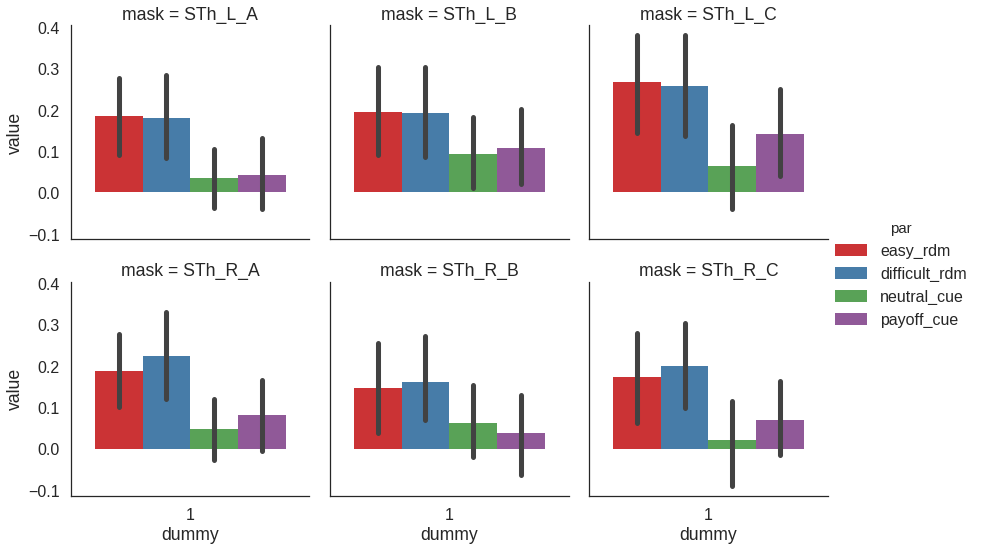

In [279]:
df_glm = pandas.DataFrame(level2_dict)
df_glm = df_glm.query('par != "constant"')
df_glm['dummy'] = 1

df_glm['% signal change'] = df_glm['value']
sns.set_palette('Set1')
sns.set_context('poster')
sns.set_style('white')

# sns.factorplot(x='dummy', y='value', hue='par', data=df_glm, col='mask', col_wrap=3, kind='bar', ci=95, hue_order=['payoff_cue (left)', 'payoff_cue (right)', 'neutral_cue','difficult_rdm', 'easy_rdm'])
sns.factorplot(x='dummy', y='value', hue='par', data=df_glm, col='mask', col_wrap=3, kind='bar', ci=95)

In [280]:
import itertools
import pyfir
from nipy.modalities.fmri import design_matrix, experimental_paradigm
import statsmodels.api as sm

level2_dict = []
adj_r = []
# pars = ['neutral_cue', 'left_cue', 'right_cue', 'neutral_easy_correct', 'valid_easy_correct', 'invalid_easy_correct', 'neutral_hard_correct', 'valid_hard_correct', 'invalid_hard_correct', 'easy_error', 'hard_error',]
# pars = 

mask = 'STh_L'

for subject_id in np.arange(1, 20):
    for run in [1,2,3]:

        try:
            onsets_dict = get_onsets(subject_id, run, 'model1a', shift=-3)
            pars = onsets_dict.keys()

            conditions = []
            onsets = []
            for key in onsets_dict.keys():
                conditions += [key] * len(onsets_dict[key])
                onsets += onsets_dict[key]

            paradigm =  experimental_paradigm.BlockParadigm(con_id=conditions, 
                                                            onset=onsets,
                                                            duration=[[1.]] * len(conditions))
            tr = 3.0
            frametimes = np.linspace(0, 387 * tr, 387)
            hrf_model = 'Canonical'

            X, names= design_matrix.dmtx_light(frametimes, paradigm, hrf_model=hrf_model, drift_model='polynomial', fir_delays=np.arange(11), drift_order=3)

            X /= X.max(0)
            X = pandas.DataFrame(X, columns=names)

            for i, mask in enumerate(['STh_L_A', 'STh_L_B', 'STh_L_C', 'STh_R_A', 'STh_R_B', 'STh_R_C']):
                signal = get_signal(subject_id,  run, mask)
                r = sm.GLSAR(signal, X).iterative_fit()

                adj_r.append({'subject_id':subject_id, 'mask':mask, 'r2_adj':r.rsquared_adj, 'r2':r.rsquared, 'run':run})

                for par in pars:
                    level2_dict.append({'value':r.params[par],
                                        'par':par,
                                        'subject_id':subject_id,
                                        'mask':mask,
                                        'run':run})
        except Exception as e:
            print 'Error: %s/%s/%s' %  (subject_id, mask, e)

Error: 6/STh_R_C/all the input arrays must have same number of dimensions


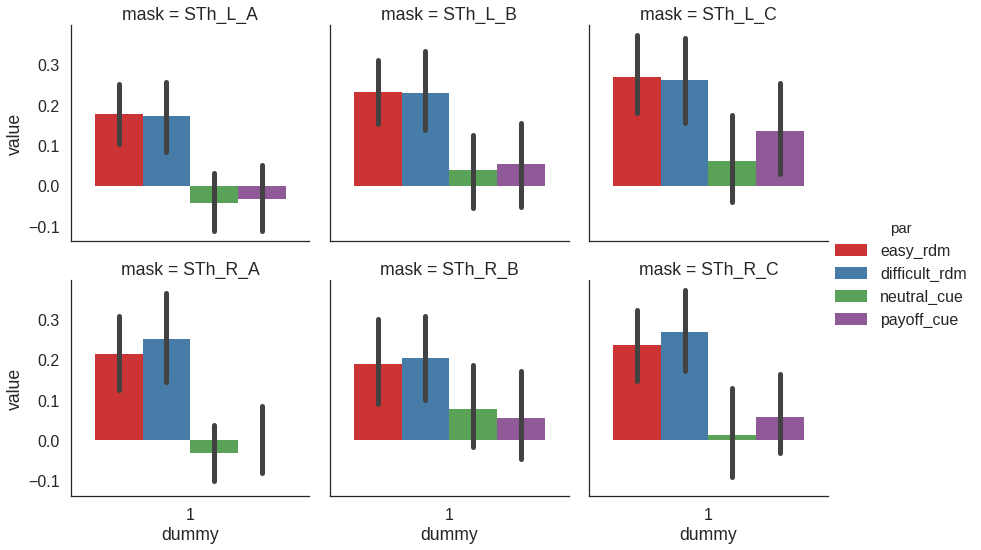

In [281]:
df_glm = pandas.DataFrame(level2_dict)
df_glm = df_glm.query('par != "constant"')
df_glm['dummy'] = 1

df_glm['% signal change'] = df_glm['value']
sns.set_palette('Set1')
sns.set_context('poster')
sns.set_style('white')

# sns.factorplot(x='dummy', y='value', hue='par', data=df_glm, col='mask', col_wrap=3, kind='bar', ci=95, hue_order=['payoff_cue (left)', 'payoff_cue (right)', 'neutral_cue','difficult_rdm', 'easy_rdm'])
sns.factorplot(x='dummy', y='value', hue='par', data=df_glm, col='mask', col_wrap=3, kind='bar', ci=95)

In [282]:
shifts = pandas.read_pickle('/home/gdholla1/projects/bias/data/derivatives/behavior/hddm/bias_shifts.pkl')
shifts = shifts.set_index('subj_idx')
tmp = df_glm.pivot_table(index='subject_id', values='value', columns=['par', 'mask'])

In [283]:

tmp = tmp['payoff_cue'] - tmp['neutral_cue']
shifts = shifts.merge(tmp, left_index=True, right_index=True)


In [284]:
masks = ['STh_L_A', 'STh_L_B', 'STh_L_C', 'STh_R_A', 'STh_R_B', 'STh_R_C']

,mask,p,r,p.fdr
0,STh_L_A,0.101637,0.387018,0.304911
1,STh_L_B,0.172505,0.326477,0.345010
2,STh_L_C,0.569516,0.139302,0.798864
3,STh_R_A,0.003199,0.639445,0.019194
4,STh_R_B,0.879375,-0.037340,0.879375
5,STh_R_C,0.665720,0.106033,0.798864


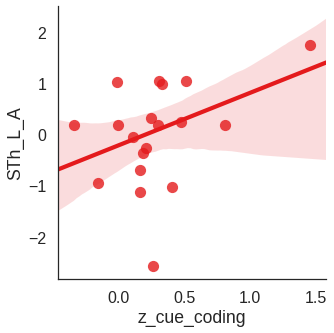

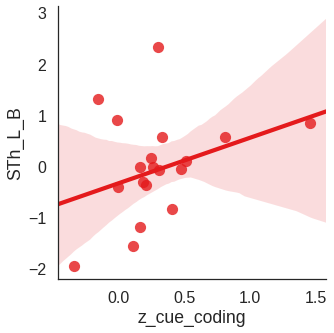

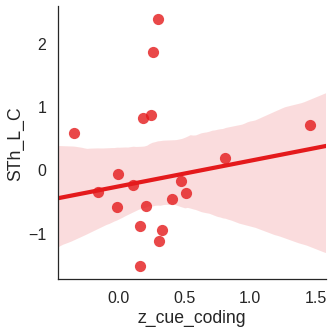

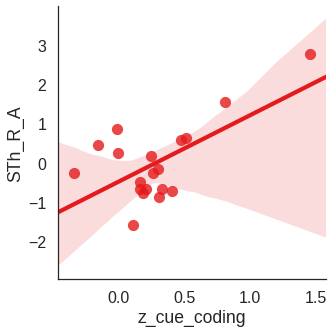

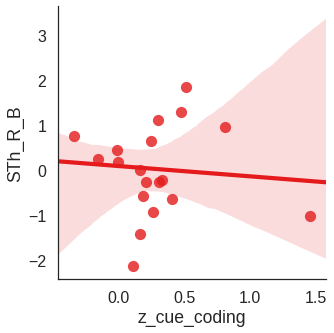

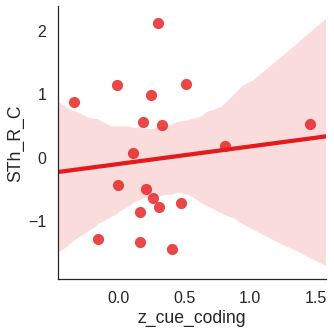

In [301]:
results = []

for mask in masks:
    
    shifts[mask] = (shifts[mask] - shifts[mask].mean()) / shifts[mask].std()
    
    sns.lmplot('z_cue_coding', mask, shifts, robust=True)
    
    r, p = sp.stats.pearsonr(shifts['z_cue_coding'], shifts[mask])
#     r_, p_ = sp.stats.spearmanr(shifts['z_cue_coding'], shifts[mask])
    
    results.append({'mask':mask, 'r':r, 'p':p, })
    
results = pandas.DataFrame(results)
_, p_fdr, _, _ = statsmodels.sandbox.stats.multicomp.multipletests(results['p'], method='fdr_bh')
results['p.fdr'] = p_fdr
results

In [296]:
%%R -i shifts -o chains
library(BayesFactor)

bf = regressionBF(z_cue_coding ~ 1 + STh_L_A + STh_L_B + STh_L_C, data = shifts, whichModels='all')
print(bf)

bf = regressionBF(z_cue_coding ~ 1 + STh_R_A + STh_R_B + STh_R_C, data = shifts, whichModels='all')
print(bf)

chains = posterior(bf[4], iterations=10000)

summary(chains)

  |======================================================================| 100%
Bayes factor analysis
--------------
[1] STh_L_A                     : 1.095698  ±0%
[2] STh_L_B                     : 0.8039913 ±0%
[3] STh_L_C                     : 0.454849  ±0%
[4] STh_L_A + STh_L_B           : 0.7836507 ±0%
[5] STh_L_A + STh_L_C           : 0.7016302 ±0%
[6] STh_L_B + STh_L_C           : 0.4050914 ±0%
[7] STh_L_A + STh_L_B + STh_L_C : 0.4657457 ±0%

Against denominator:
  Intercept only 
---
Bayes factor type: BFlinearModel, JZS

  |======================================================================| 100%
Bayes factor analysis
--------------
[1] STh_R_A                     : 12.10436  ±0%
[2] STh_R_B                     : 0.4076567 ±0%
[3] STh_R_C                     : 0.4326829 ±0%
[4] STh_R_A + STh_R_B           : 11.5169   ±0%
[5] STh_R_A + STh_R_C           : 4.533414  ±0%
[6] STh_R_B + STh_R_C           : 0.2439099 ±0%
[7] STh_R_A + STh_R_B + STh_R_C : 4.882465  ±0%

Against de

0.99319999999999997

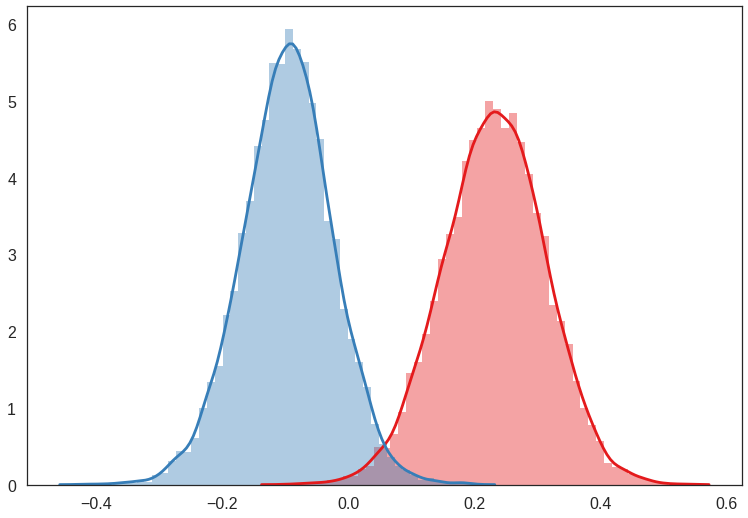

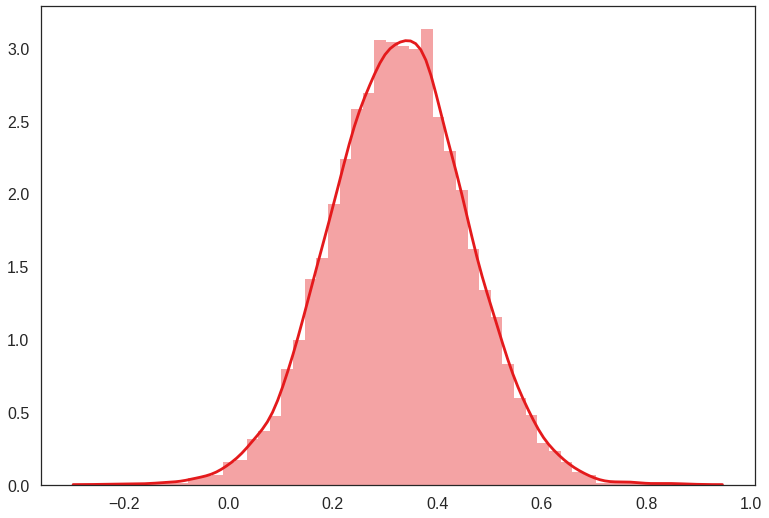

In [297]:
sns.distplot(chains[: ,0])
sns.distplot(chains[: ,1])

plt.figure()
sns.distplot(chains[: ,0] - chains[: ,1])

((chains[: ,0] - chains[: ,1]) > 0).mean()

# Model 1b



In [233]:
import itertools
import pyfir
from nipy.modalities.fmri import design_matrix, experimental_paradigm
import statsmodels.api as sm

level2_dict = []
adj_r = []
# pars = ['neutral_cue', 'left_cue', 'right_cue', 'neutral_easy_correct', 'valid_easy_correct', 'invalid_easy_correct', 'neutral_hard_correct', 'valid_hard_correct', 'invalid_hard_correct', 'easy_error', 'hard_error',]
# pars = 

mask = 'STh_L'

for subject_id in np.arange(1, 20):
    for run in [1,2,3]:

        try:
            onsets_dict = get_onsets(subject_id, run, 'model1b', shift=-3)
            pars = onsets_dict.keys()

            conditions = []
            onsets = []
            for key in onsets_dict.keys():
                conditions += [key] * len(onsets_dict[key])
                onsets += onsets_dict[key]

            paradigm =  experimental_paradigm.BlockParadigm(con_id=conditions, 
                                                            onset=onsets,
                                                            duration=[[1.]] * len(conditions))
            tr = 3.0
            frametimes = np.linspace(0, 387 * tr, 387)
            hrf_model = 'Canonical'

            X, names= design_matrix.dmtx_light(frametimes, paradigm, hrf_model=hrf_model, drift_model='polynomial', fir_delays=np.arange(11), drift_order=3)

            X /= X.max(0)
            X = pandas.DataFrame(X, columns=names)

            for i, mask in enumerate(['STh_L_A', 'STh_L_B', 'STh_L_C', 'STh_R_A', 'STh_R_B', 'STh_R_C']):
                signal = get_signal(subject_id,  run, mask)
                r = sm.GLSAR(signal, X).iterative_fit()

                adj_r.append({'subject_id':subject_id, 'mask':mask, 'r2_adj':r.rsquared_adj, 'r2':r.rsquared, 'run':run})

                for par in pars:
                    level2_dict.append({'value':r.params[par],
                                        'par':par,
                                        'subject_id':subject_id,
                                        'mask':mask,
                                        'run':run})
        except Exception as e:
            print 'Error: %s/%s/%s' %  (subject_id, mask, e)

Error: 6/STh_R_C/all the input arrays must have same number of dimensions


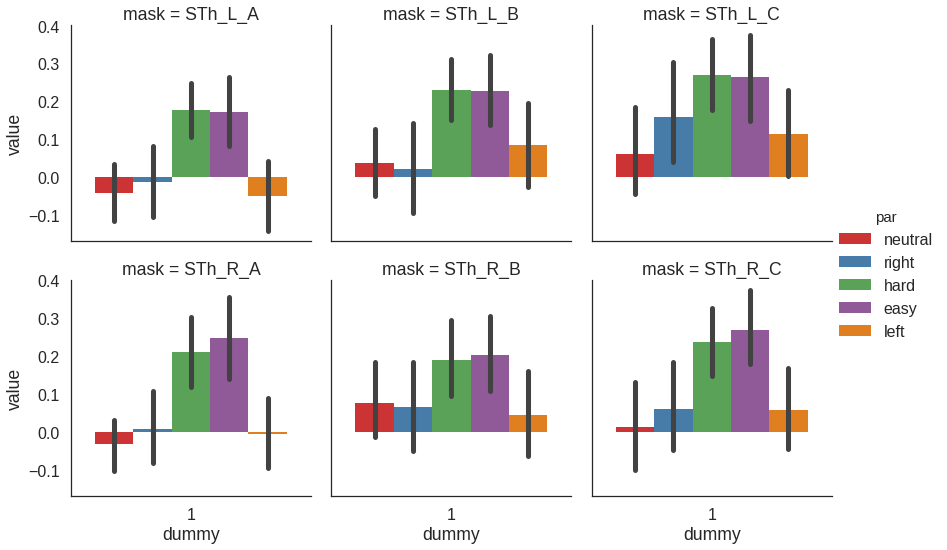

In [234]:
df_glm = pandas.DataFrame(level2_dict)
df_glm = df_glm.query('par != "constant"')
df_glm['dummy'] = 1

df_glm['% signal change'] = df_glm['value']
sns.set_palette('Set1')
sns.set_context('poster')
sns.set_style('white')

# sns.factorplot(x='dummy', y='value', hue='par', data=df_glm, col='mask', col_wrap=3, kind='bar', ci=95, hue_order=['payoff_cue (left)', 'payoff_cue (right)', 'neutral_cue','difficult_rdm', 'easy_rdm'])
sns.factorplot(x='dummy', y='value', hue='par', data=df_glm, col='mask', col_wrap=3, kind='bar', ci=95)

In [235]:
shifts = pandas.read_pickle('/home/gdholla1/projects/bias/data/derivatives/behavior/hddm/bias_shifts.pkl')
shifts = shifts.set_index('subj_idx')
tmp = df_glm.pivot_table(index='subject_id', values='value', columns=['par', 'mask'])
tmp = tmp['left'] - tmp['neutral']
shifts = shifts.merge(tmp, left_index=True, right_index=True)


,mask,p,r,p.fdr
0,STh_L_A,0.159133,0.336348,0.318266
1,STh_L_B,0.045114,0.464495,0.135342
2,STh_L_C,0.459875,0.180399,0.607287
3,STh_R_A,0.009144,0.580629,0.054863
4,STh_R_B,0.623944,0.120228,0.623944
5,STh_R_C,0.506073,0.162570,0.607287


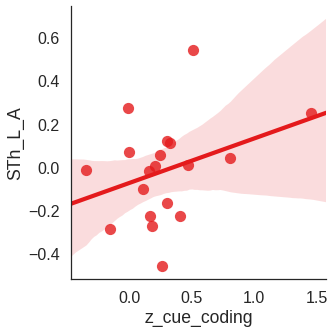

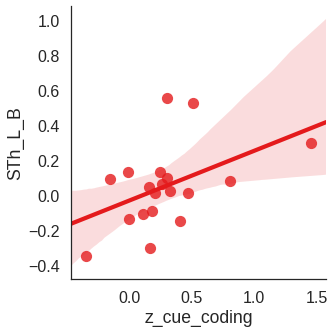

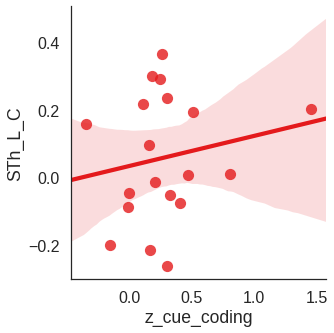

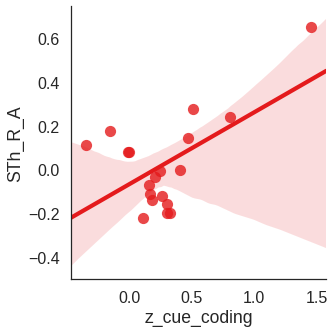

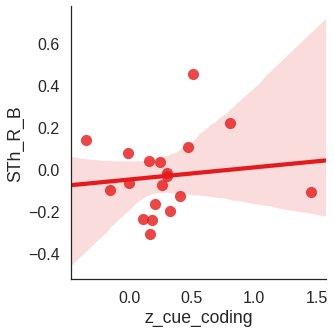

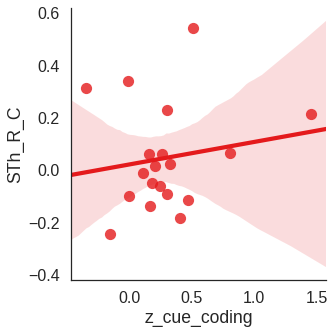

In [236]:
shifts = pandas.read_pickle('/home/gdholla1/projects/bias/data/derivatives/behavior/hddm/bias_shifts.pkl')
shifts = shifts.set_index('subj_idx')
tmp = df_glm.pivot_table(index='subject_id', values='value', columns=['par', 'mask'])
tmp = tmp['left'] - tmp['neutral']
shifts = shifts.merge(tmp, left_index=True, right_index=True)

results = []

for mask in masks:
    sns.lmplot('z_cue_coding', mask, shifts)
    
    r, p = sp.stats.pearsonr(shifts['z_cue_coding'], shifts[mask])
    
    results.append({'mask':mask, 'r':r, 'p':p})
    
results = pandas.DataFrame(results)
_, p_fdr, _, _ = statsmodels.sandbox.stats.multicomp.multipletests(results['p'], method='fdr_bh')
results['p.fdr'] = p_fdr
results

In [237]:
%%R -i shifts
library(BayesFactor)

bf = regressionBF(z_cue_coding ~ 1 + STh_L_A + STh_L_B + STh_L_C, data = shifts, whichModels='all')
print(bf)

bf = regressionBF(z_cue_coding ~ 1 + STh_R_A + STh_R_B + STh_R_C, data = shifts, whichModels='all')
print(bf)

  |======================================================================| 100%
Bayes factor analysis
--------------
[1] STh_L_A                     : 0.8415289 ±0%
[2] STh_L_B                     : 1.832123  ±0%
[3] STh_L_C                     : 0.4935027 ±0%
[4] STh_L_A + STh_L_B           : 0.9854889 ±0%
[5] STh_L_A + STh_L_C           : 0.5547191 ±0%
[6] STh_L_B + STh_L_C           : 0.8492104 ±0%
[7] STh_L_A + STh_L_B + STh_L_C : 0.5522766 ±0%

Against denominator:
  Intercept only 
---
Bayes factor type: BFlinearModel, JZS

  |======================================================================| 100%
Bayes factor analysis
--------------
[1] STh_R_A                     : 5.543004  ±0%
[2] STh_R_B                     : 0.4412454 ±0%
[3] STh_R_C                     : 0.4750373 ±0%
[4] STh_R_A + STh_R_B           : 2.808703  ±0%
[5] STh_R_A + STh_R_C           : 2.230734  ±0%
[6] STh_R_B + STh_R_C           : 0.2537567 ±0%
[7] STh_R_A + STh_R_B + STh_R_C : 1.395749  ±0%

Against de

,mask,p,r,p.fdr
0,STh_L_A,0.231653,0.288100,0.694958
1,STh_L_B,0.855156,0.044906,0.885029
2,STh_L_C,0.846406,0.047649,0.885029
3,STh_R_A,0.007574,0.592028,0.045444
4,STh_R_B,0.422739,-0.195400,0.845478
5,STh_R_C,0.885029,-0.035578,0.885029


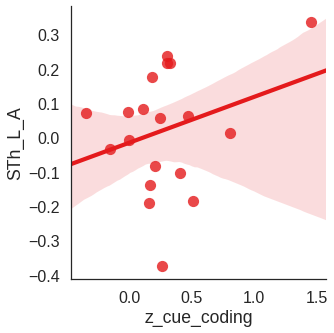

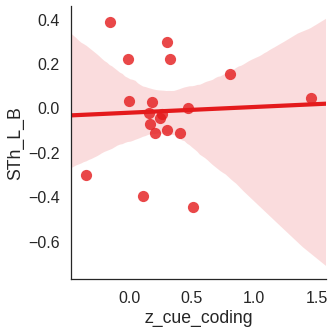

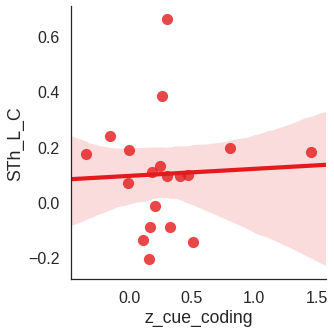

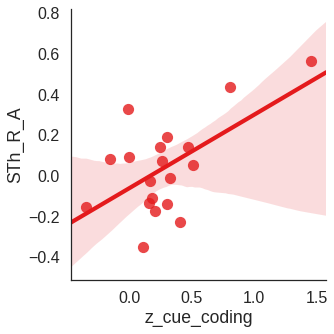

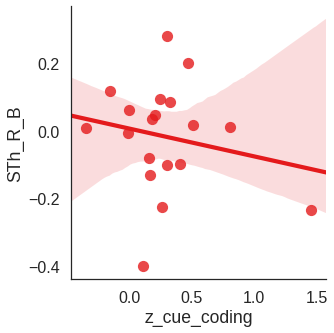

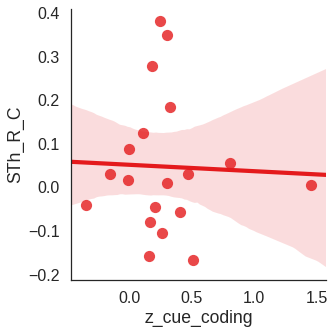

In [238]:
shifts = pandas.read_pickle('/home/gdholla1/projects/bias/data/derivatives/behavior/hddm/bias_shifts.pkl')
shifts = shifts.set_index('subj_idx')
tmp = df_glm.pivot_table(index='subject_id', values='value', columns=['par', 'mask'])
tmp = tmp['right'] - tmp['neutral']
shifts = shifts.merge(tmp, left_index=True, right_index=True)

results = []

for mask in masks:
    sns.lmplot('z_cue_coding', mask, shifts)
    
    r, p = sp.stats.pearsonr(shifts['z_cue_coding'], shifts[mask])
    
    results.append({'mask':mask, 'r':r, 'p':p})
    
results = pandas.DataFrame(results)
_, p_fdr, _, _ = statsmodels.sandbox.stats.multicomp.multipletests(results['p'], method='fdr_bh')
results['p.fdr'] = p_fdr
results

In [239]:
%%R -i shifts
library(BayesFactor)

bf = regressionBF(z_cue_coding ~ 1 + STh_L_A + STh_L_B + STh_L_C, data = shifts, whichModels='all')
print(bf)

bf = regressionBF(z_cue_coding ~ 1 + STh_R_A + STh_R_B + STh_R_C, data = shifts, whichModels='all')
print(bf)

  |======================================================================| 100%
Bayes factor analysis
--------------
[1] STh_L_A                     : 0.6844455 ±0%
[2] STh_L_B                     : 0.4091851 ±0%
[3] STh_L_C                     : 0.4098106 ±0%
[4] STh_L_A + STh_L_B           : 0.3526497 ±0%
[5] STh_L_A + STh_L_C           : 0.3499384 ±0%
[6] STh_L_B + STh_L_C           : 0.2225549 ±0%
[7] STh_L_A + STh_L_B + STh_L_C : 0.2078282 ±0%

Against denominator:
  Intercept only 
---
Bayes factor type: BFlinearModel, JZS

  |======================================================================| 100%
Bayes factor analysis
--------------
[1] STh_R_A                     : 6.359203  ±0%
[2] STh_R_B                     : 0.5113045 ±0%
[3] STh_R_C                     : 0.4073421 ±0%
[4] STh_R_A + STh_R_B           : 8.512376  ±0%
[5] STh_R_A + STh_R_C           : 2.824732  ±0%
[6] STh_R_B + STh_R_C           : 0.2738131 ±0%
[7] STh_R_A + STh_R_B + STh_R_C : 3.600074  ±0.01%

Against

# Difficulty

# Include errors

In [240]:
import itertools
import pyfir
from nipy.modalities.fmri import design_matrix, experimental_paradigm
import statsmodels.api as sm

level2_dict = []
adj_r = []
# pars = ['neutral_cue', 'left_cue', 'right_cue', 'neutral_easy_correct', 'valid_easy_correct', 'invalid_easy_correct', 'neutral_hard_correct', 'valid_hard_correct', 'invalid_hard_correct', 'easy_error', 'hard_error',]
# pars = 

mask = 'STh_L'

for subject_id in np.arange(1, 20):
    for run in [1,2,3]:

        try:
            onsets_dict = get_onsets(subject_id, run, 'model1a', shift=-3)
            pars = onsets_dict.keys()

            conditions = []
            onsets = []
            for key in onsets_dict.keys():
                conditions += [key] * len(onsets_dict[key])
                onsets += onsets_dict[key]

            paradigm =  experimental_paradigm.BlockParadigm(con_id=conditions, 
                                                            onset=onsets,
                                                            duration=[[1.]] * len(conditions))
            tr = 3.0
            frametimes = np.linspace(0, 387 * tr, 387)
            hrf_model = 'Canonical with Derivative'

            X, names= design_matrix.dmtx_light(frametimes, paradigm, hrf_model=hrf_model, drift_model='polynomial', fir_delays=np.arange(11), drift_order=3)

            X /= X.max(0)
            X = pandas.DataFrame(X, columns=names)

            for i, mask in enumerate(['STh_L_A', 'STh_L_B', 'STh_L_C', 'STh_R_A', 'STh_R_B', 'STh_R_C']):
                signal = get_signal(subject_id,  run, mask)
                r = sm.GLSAR(signal, X).iterative_fit()

                adj_r.append({'subject_id':subject_id, 'mask':mask, 'r2_adj':r.rsquared_adj, 'r2':r.rsquared, 'run':run})

                for par in pars:
                    level2_dict.append({'value':r.params[par],
                                        'par':par,
                                        'subject_id':subject_id,
                                        'mask':mask,
                                        'run':run})
        except Exception as e:
            print 'Error: %s/%s/%s' %  (subject_id, mask, e)

Error: 6/STh_R_C/all the input arrays must have same number of dimensions


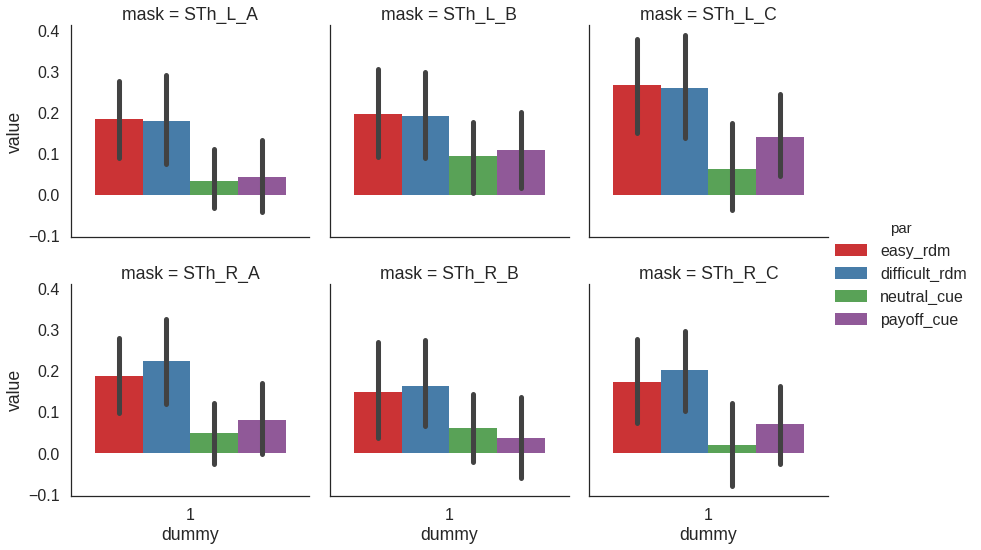

In [241]:
df_glm = pandas.DataFrame(level2_dict)
df_glm = df_glm.query('par != "constant"')
df_glm['dummy'] = 1

df_glm['% signal change'] = df_glm['value']
sns.set_palette('Set1')
sns.set_context('poster')
sns.set_style('white')

# sns.factorplot(x='dummy', y='value', hue='par', data=df_glm, col='mask', col_wrap=3, kind='bar', ci=95, hue_order=['payoff_cue (left)', 'payoff_cue (right)', 'neutral_cue','difficult_rdm', 'easy_rdm'])
sns.factorplot(x='dummy', y='value', hue='par', data=df_glm, col='mask', col_wrap=3, kind='bar', ci=95)

In [242]:
shifts = pandas.read_pickle('/home/gdholla1/projects/bias/data/derivatives/behavior/hddm/bias_shifts.pkl')
shifts = shifts.set_index('subj_idx')
tmp = df_glm.pivot_table(index='subject_id', values='value', columns=['par', 'mask'])

tmp = tmp['difficult_rdm'] - tmp['easy_rdm']
shifts = shifts.merge(tmp, left_index=True, right_index=True)

,mask,p,r,p.fdr
0,STh_L_A,0.081325,0.409921,0.487947
1,STh_L_B,0.378467,-0.214235,0.546418
2,STh_L_C,0.466642,0.177733,0.546418
3,STh_R_A,0.211896,-0.300112,0.502764
4,STh_R_B,0.546418,-0.147630,0.546418
5,STh_R_C,0.251382,-0.276748,0.502764


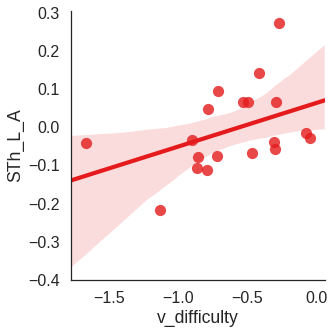

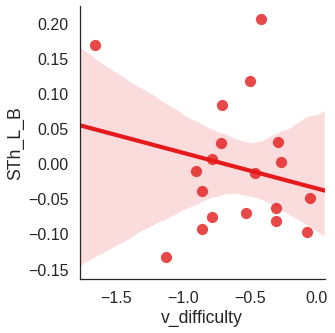

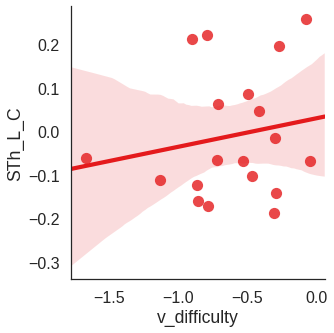

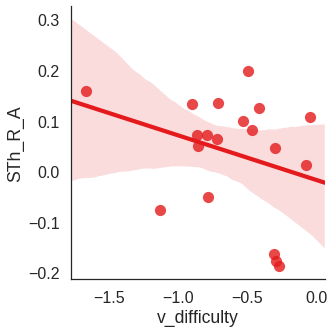

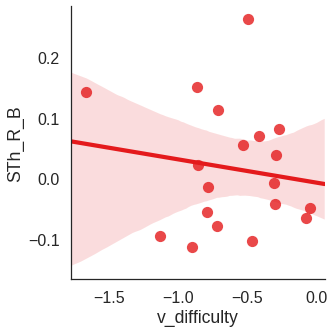

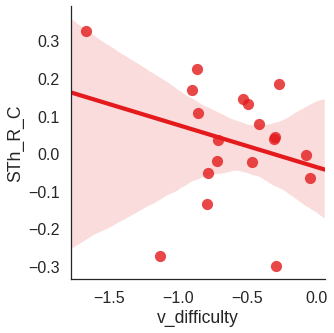

In [243]:
results = []

for mask in masks:
    sns.lmplot('v_difficulty', mask, shifts)
    
    r, p = sp.stats.pearsonr(shifts['v_difficulty'], shifts[mask])
    
    results.append({'mask':mask, 'r':r, 'p':p})
    
results = pandas.DataFrame(results)
_, p_fdr, _, _ = statsmodels.sandbox.stats.multicomp.multipletests(results['p'], method='fdr_bh')
results['p.fdr'] = p_fdr
results

In [245]:
%%R -i shifts
library(BayesFactor)

bf = regressionBF(v_cue_coding ~ 1 + STh_L_A + STh_L_B + STh_L_C, data = shifts, whichModels='all')
print(bf)

bf = regressionBF(v_cue_coding ~ 1 + STh_R_A + STh_R_B + STh_R_C, data = shifts, whichModels='all')
print(bf)

  |======================================================================| 100%
Bayes factor analysis
--------------
[1] STh_L_A                     : 1.433243  ±0%
[2] STh_L_B                     : 0.6423944 ±0%
[3] STh_L_C                     : 0.8142755 ±0%
[4] STh_L_A + STh_L_B           : 0.7078726 ±0%
[5] STh_L_A + STh_L_C           : 0.9116565 ±0%
[6] STh_L_B + STh_L_C           : 0.5364149 ±0%
[7] STh_L_A + STh_L_B + STh_L_C : 0.5052046 ±0%

Against denominator:
  Intercept only 
---
Bayes factor type: BFlinearModel, JZS

  |======================================================================| 100%
Bayes factor analysis
--------------
[1] STh_R_A                     : 0.4090896 ±0%
[2] STh_R_B                     : 0.9827842 ±0%
[3] STh_R_C                     : 0.7125922 ±0%
[4] STh_R_A + STh_R_B           : 0.4884572 ±0%
[5] STh_R_A + STh_R_C           : 0.3843276 ±0%
[6] STh_R_B + STh_R_C           : 0.5359507 ±0%
[7] STh_R_A + STh_R_B + STh_R_C : 0.3231983 ±0%

Against de

# Without errors

In [246]:
import itertools
import pyfir
from nipy.modalities.fmri import design_matrix, experimental_paradigm
import statsmodels.api as sm

level2_dict = []
adj_r = []
# pars = ['neutral_cue', 'left_cue', 'right_cue', 'neutral_easy_correct', 'valid_easy_correct', 'invalid_easy_correct', 'neutral_hard_correct', 'valid_hard_correct', 'invalid_hard_correct', 'easy_error', 'hard_error',]
# pars = 

mask = 'STh_L'

for subject_id in np.arange(1, 20):
    for run in [1,2,3]:

        try:
            onsets_dict = get_onsets(subject_id, run, 'model1c', shift=-3)
            pars = onsets_dict.keys()

            conditions = []
            onsets = []
            for key in onsets_dict.keys():
                conditions += [key] * len(onsets_dict[key])
                onsets += onsets_dict[key]

            paradigm =  experimental_paradigm.BlockParadigm(con_id=conditions, 
                                                            onset=onsets,
                                                            duration=[[1.]] * len(conditions))
            tr = 3.0
            frametimes = np.linspace(0, 387 * tr, 387)
            hrf_model = 'Canonical with Derivative'

            X, names= design_matrix.dmtx_light(frametimes, paradigm, hrf_model=hrf_model, drift_model='polynomial', fir_delays=np.arange(11), drift_order=3)

            X /= X.max(0)
            X = pandas.DataFrame(X, columns=names)

            for i, mask in enumerate(['STh_L_A', 'STh_L_B', 'STh_L_C', 'STh_R_A', 'STh_R_B', 'STh_R_C']):
                signal = get_signal(subject_id,  run, mask)
                r = sm.GLSAR(signal, X).iterative_fit()

                adj_r.append({'subject_id':subject_id, 'mask':mask, 'r2_adj':r.rsquared_adj, 'r2':r.rsquared, 'run':run})

                for par in pars:
                    level2_dict.append({'value':r.params[par],
                                        'par':par,
                                        'subject_id':subject_id,
                                        'mask':mask,
                                        'run':run})
        except Exception as e:
            print 'Error: %s/%s/%s' %  (subject_id, mask, e)

Error: 6/STh_R_C/all the input arrays must have same number of dimensions


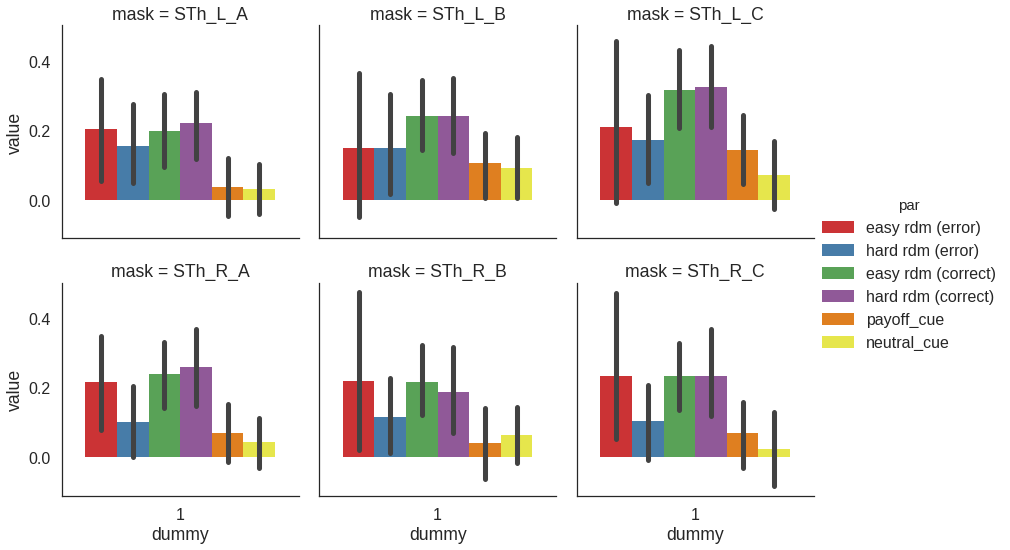

In [247]:
df_glm = pandas.DataFrame(level2_dict)
df_glm = df_glm.query('par != "constant"')
df_glm['dummy'] = 1

df_glm['% signal change'] = df_glm['value']
sns.set_palette('Set1')
sns.set_context('poster')
sns.set_style('white')

# sns.factorplot(x='dummy', y='value', hue='par', data=df_glm, col='mask', col_wrap=3, kind='bar', ci=95, hue_order=['payoff_cue (left)', 'payoff_cue (right)', 'neutral_cue','difficult_rdm', 'easy_rdm'])
sns.factorplot(x='dummy', y='value', hue='par', data=df_glm, col='mask', col_wrap=3, kind='bar', ci=95)

In [248]:
shifts = pandas.read_pickle('/home/gdholla1/projects/bias/data/derivatives/behavior/hddm/bias_shifts.pkl')
shifts = shifts.set_index('subj_idx')
tmp = df_glm.pivot_table(index='subject_id', values='value', columns=['par', 'mask'])

tmp = tmp['hard rdm (correct)'] - tmp['easy rdm (correct)']
shifts = shifts.merge(tmp, left_index=True, right_index=True)

In [249]:
from statsmodels.sandbox.stats import multicomp

In [250]:
import statsmodels

,mask,p,r,p.fdr
0,STh_L_A,0.419305,-0.196821,0.838610
1,STh_L_B,0.957400,0.013147,0.957400
2,STh_L_C,0.024563,-0.513400,0.147377
3,STh_R_A,0.133601,0.356914,0.400802
4,STh_R_B,0.841266,-0.049263,0.957400
5,STh_R_C,0.754720,0.076781,0.957400


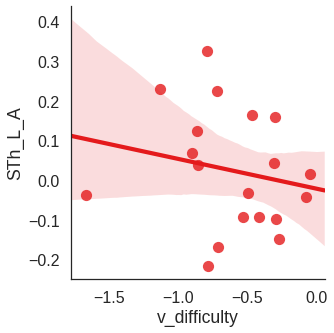

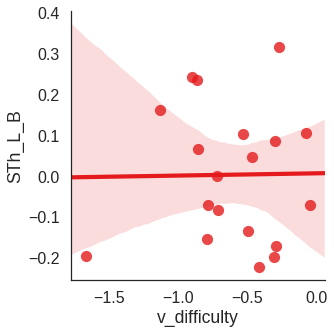

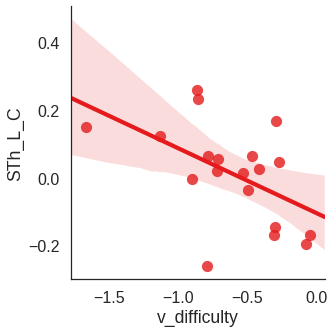

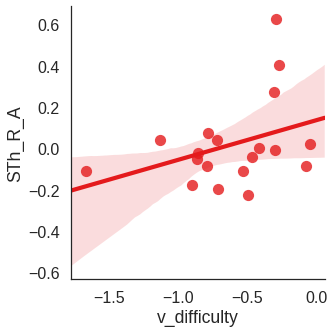

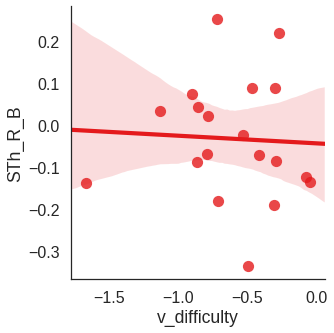

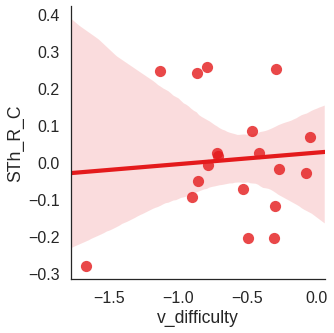

In [199]:
results = []

for mask in masks:
    sns.lmplot('v_difficulty', mask, shifts)
    
    r, p = sp.stats.pearsonr(shifts['v_difficulty'], shifts[mask])
    
    results.append({'mask':mask, 'r':r, 'p':p})
    
results = pandas.DataFrame(results)
_, p_fdr, _, _ = statsmodels.sandbox.stats.multicomp.multipletests(results['p'], method='fdr_bh')
results['p.fdr'] = p_fdr
results

In [274]:
%%R -i shifts -o chains
library(BayesFactor)

bf = regressionBF(v_difficulty ~ 1 + STh_L_A + STh_L_B + STh_L_C, data = shifts, whichModels='all')
print(bf)

bf = regressionBF(v_difficulty ~ 1 + STh_R_A + STh_R_B + STh_R_C, data = shifts, whichModels='all')
print(bf)


chains = posterior(bf[4], iterations = 1000)
print(summary(chains))

  |======================================================================| 100%
Bayes factor analysis
--------------
[1] STh_L_A                     : 0.513107  ±0%
[2] STh_L_B                     : NA        ±NA%
[3] STh_L_C                     : 2.756678  ±0.01%
[4] STh_L_A + STh_L_B           : 0.2735582 ±0%
[5] STh_L_A + STh_L_C           : 2.835412  ±0%
[6] STh_L_B + STh_L_C           : 1.38006   ±0%
[7] STh_L_A + STh_L_B + STh_L_C : 1.928123  ±0%

Against denominator:
  Intercept only 
---
Bayes factor type: BFlinearModel, JZS

  |======================================================================| 100%
Bayes factor analysis
--------------
[1] STh_R_A                     : 0.9309306 ±0%
[2] STh_R_B                     : 0.4101966 ±0%
[3] STh_R_C                     : 0.4188699 ±0%
[4] STh_R_A + STh_R_B           : 0.5233798 ±0%
[5] STh_R_A + STh_R_C           : 0.4610387 ±0%
[6] STh_R_B + STh_R_C           : 0.2314831 ±0%
[7] STh_R_A + STh_R_B + STh_R_C : 0.29683   ±0%

Agains

In [275]:
chains.shape

(1000, 4)

In [276]:
((chains[:, 0] - chains[:, 1]) > 0).mean()

0.84399999999999997

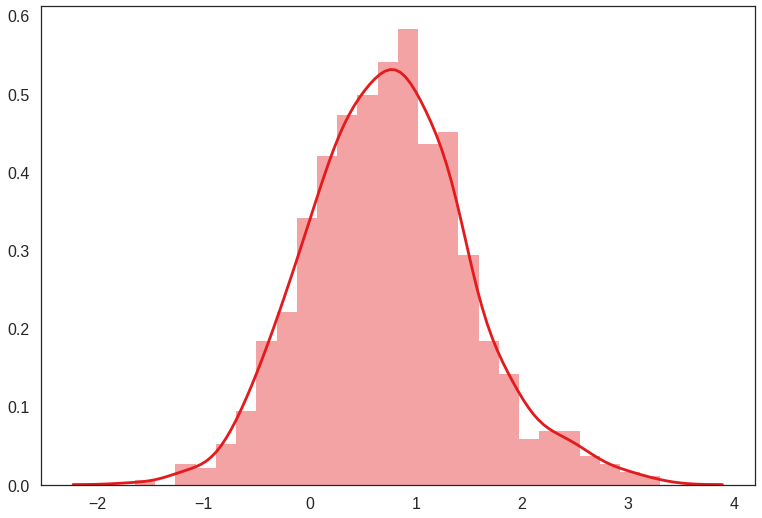

In [277]:
sns.distplot(chains[:, 0] - chains[:, 1])

In [255]:
shifts

,v_cue_coding,v_difficulty,z_cue_coding,STh_L_A,STh_L_B,STh_L_C,STh_R_A,STh_R_B,STh_R_C
subj_idx,,,,,,,,,
1,-0.148440,-0.786935,-0.004807,-0.216441,-0.070005,0.062908,0.071986,0.022180,-0.007647
2,0.008400,-0.418274,0.209395,-0.092983,-0.222514,0.025672,0.000406,-0.071918,0.024872
3,-0.189604,-0.532316,0.304420,-0.092872,0.102735,0.014317,-0.109142,-0.024227,-0.074343
4,1.302674,-0.050203,0.328166,0.015400,-0.070891,-0.169711,0.019866,-0.135904,0.068478
5,0.195892,-0.787838,-0.012188,0.326816,-0.152584,-0.261649,-0.084182,-0.067681,0.257306
6,0.747321,-0.862304,0.260270,0.124024,0.235121,0.259613,-0.053663,-0.088164,0.239853
7,-0.338653,-0.709117,0.247486,-0.167952,-0.082240,0.053541,-0.197979,-0.180312,0.016453
8,0.299781,-0.304853,0.301060,0.043487,-0.197689,-0.169889,0.274432,-0.190085,-0.205083
9,-0.316918,-0.497399,0.469534,-0.031134,-0.133385,-0.037713,-0.226926,-0.336156,-0.206193
